In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import ReLU,MaxPooling2D,Activation
from tensorflow.keras.layers import (Conv2D,LeakyReLU,Dense,Flatten,ZeroPadding2D,
                                     Dropout,BatchNormalization,UpSampling2D,
                                     GlobalMaxPooling2D,Reshape,Conv2DTranspose)
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, callbacks
from glob import glob
from PIL import Image, ImageSequence
import keras
import pickle


In [2]:
cd /kaggle/working/

/kaggle/working


In [3]:
ls

__notebook_source__.ipynb


In [4]:
latent_dim= 128
batch_size = 64

In [5]:
image_path = glob("/kaggle/input/anime-faces/data/data/*")
print("Dataset Size: ", len(image_path))

Dataset Size:  21551


In [6]:
def load_data():
        data = []
        paths = []
        for r, d, f in os.walk(r'../input/anime-faces/data/data'):
            for file in f:
                if '.png' in file:
                    paths.append(os.path.join(r, file))

        for path in paths:
            img = Image.open(path)
            x = np.array(img)
            x = x[...,:3]
            if(x.shape == (64,64,3)):
                data.append(x)

        x_train = np.array(data)
        x_train = x_train.reshape(len(data),64,64,3)
        return x_train

images = load_data()

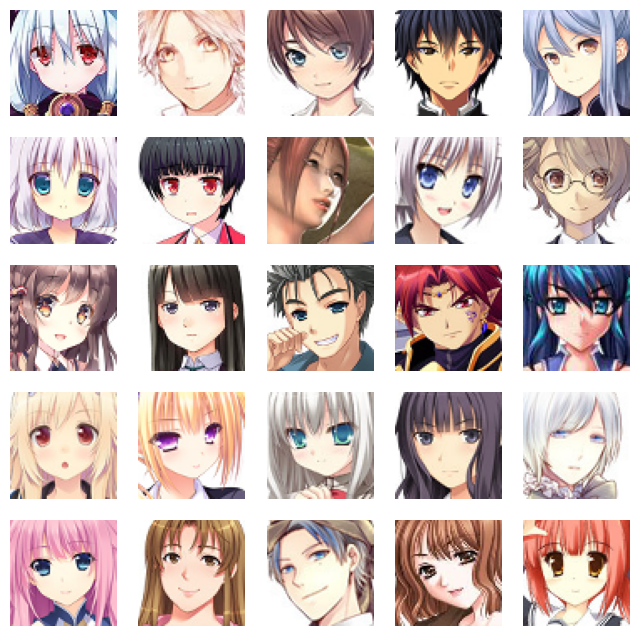

In [7]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [8]:
# Image preprocessonig
def preprocess(images):
    images = images.astype('float32') /255
    images = np.reshape(images,(-1,64,64,3))
    images = tf.data.Dataset.from_tensor_slices(images)
    images = images.shuffle(buffer_size=1024).batch(batch_size).prefetch(3)
    return images

dataset = preprocess(images)

In [9]:
class Create_Models():
    def __init__(self,latent_dim):
        self.latent_dim= latent_dim
        self.noise_size = 100
        self.epsilon = 0.0001
    def build_disc(self):
        model = Sequential()
#         model.add(ZeroPadding2D(padding=(1, 1), input_shape=(64, 64,3)))
        model.add(Conv2D(128, (3,3), padding='same', input_shape=(64, 64,3)))
        model.add(ReLU())
        model.add(BatchNormalization())
            
        model.add(Conv2D(256,3,padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=3, strides=3))
        model.add(Dropout(0.25))

        model.add(Conv2D(128,3,strides=1,padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Conv2D(128,3,strides=1,padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        
        
        model.add(Conv2D(128,3,strides=1,padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Conv2D(64,3,strides=1,padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(ReLU())
        model.add(Dense(1, activation='sigmoid'))
        
        return model
    
    def build_gen(self):
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear',input_dim =self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))        
        model.add(Conv2DTranspose(512,4,strides=2,padding='same'))
        model.add(BatchNormalization(momentum=0.9, epsilon=self.epsilon))
        model.add(LeakyReLU(alpha=0.2))

        
        model.add(Conv2DTranspose(256,4,strides=2,padding='same'))
        model.add(BatchNormalization(momentum=0.9, epsilon=self.epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128,kernel_size=[4,4], strides=[2,2],padding='same'))
        model.add(BatchNormalization(momentum=0.9, epsilon=self.epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(3, kernel_size=[4,4],activation='tanh',strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
#         model.add(Activation("tanh"))
        return model

In [10]:
creat_model = Create_Models(latent_dim)

generator= creat_model.build_gen()
discriminator= creat_model.build_disc()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        4194816   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 512)         0

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 re_lu (ReLU)                (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 256)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 256)      1024      
 hNormalization)                                      

In [13]:
class DCGAN(Model):
    def __init__(self, discriminator, generator, latent_dim,*args,**kwargs):
        super(DCGAN, self).__init__(*args,**kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_opt, g_opt,loss_fn,*args,**kwargs):
        super(DCGAN, self).compile(*args,**kwargs)
        self.d_opt = d_opt
        self.g_opt =g_opt
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        batch_size= tf.shape(real_images)[0]
        random_latent_vects = tf.random.normal(shape=(batch_size,self.latent_dim))
        gen_images = self.generator(random_latent_vects)
        combind_images= tf.concat([gen_images, real_images],axis=0)
        
        
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))],axis=0)
        labels += 0.04* tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combind_images)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        
        random_latent_vects = tf.random.normal(shape=(batch_size,self.latent_dim))
        fake_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vects))
            g_loss = self.loss_fn(fake_labels,predictions)
            

        grads = tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_opt.apply_gradients(
            zip(grads,self.generator.trainable_weights)
        )
        

        return {"d_loss":d_loss,"g_loss":g_loss}


In [14]:
class DCGAN_Monitor(callbacks.Callback):
    def __init__(self,latent_dim):
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vects =tf.random.normal(shape=(25, self.latent_dim))
        gen_images = self.model.generator(random_latent_vects)
        
        if epoch %500 == 0:
            print('Epoch {}'.format(epoch))
            
            fig,axs = plt.subplots(5,5,figsize=(8,8),sharey=True,sharex=True)        
            c=0
            for i in range(5):
                for j in range(5):
                    axs[i,j].imshow(gen_images[c,:,:,0],)
                    axs[i,j].axis('off')
                    c+=1

            fig.show()
                

In [ ]:

m=0
for _ in range(50):
    epochs=50
    dcgan = DCGAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/checkpoints/checkpoint', save_weights_only=True)
    dcgan.compile(
        d_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
        g_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    )
#     dcgan.load_weights(tf.train.latest_checkpoint('checkpoints/'))

    history = dcgan.fit(dataset,epochs=epochs,callbacks=[DCGAN_Monitor(latent_dim=latent_dim),checkpoint])

    print(f'Epochs ============> {m*epochs}')
    m+=1




Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


  2/337 [..............................] - ETA: 1:55:58 - d_loss: 0.6435 - g_loss: 0.6896

In [ ]:
imgs = generator.predict(tf.random.normal((25,128,1)))
plt.close('all')
fig,axs = plt.subplots(5,5,figsize=(5,5),sharey=True,sharex=True)
 
c=0
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[(i+1)*(j+1)-1])
        axs[i,j].axis('off')
        c+=1
fig.show()